In [1]:
import pandas as pd
import numpy as np
from src.utils import regression, data_utils, plots, arima
import os
from statsmodels.api import tsa
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots

C:\Users\adity\AppData\Local\Temp\ipykernel_42584\3877312591.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
country_dfs = {}
country_codes = {"china": "CHN", "usa":"USA", "india":"IND", "albania":"ALB", "uk":"GBR", 
                 "korea":"KOR", "russia":"RUS", "ecuador":"ECU", "brazil":"BRA", "france":"FRA", 
                 "ghana":"GHA", "mexico":"MEX", "norway":"NOR", "switzerland":"CHE"}
for country_data in os.listdir("data/clean"):
    country_name = country_data.split("_")[2]
    country_df = data_utils.concatenate_gdp(f"data/clean/{country_data}", country_codes[country_name], "data/GDP_data.xlsx")
    country_df["Unnamed: 0"] = country_df["Unnamed: 0"].apply(lambda x: x.split()[0])
    country_df = country_df.drop(columns=["Military expenditure (current USD)"])
    country_df = country_df.rename(columns={"Unnamed: 0":"Year"})
    country_df = data_utils.concatenate_gdp_growth(country_df)
    country_dfs[country_name] = country_df

In [3]:
combined_df = pd.DataFrame({"Year":[],"Natural Log of GDP per capita (current US$)":[],
                            "Gross domestic savings (current US$)":[],
                            "Labor force, total":[], "Net trade in goods and services (BoP, current US$)":[],
                            "Consumer price index (2010 = 100)":[],"Foreign direct investment, net (BoP, current US$)":[],
                            "GDP":[], "gdp growth rate":[]})
developed = ["usa", "uk", "france", "switzerland", "norway", "russia", "korea"]
developing = ["india", "china", "albania", "brazil", "mexico"]
underdeveloped = ["ghana", "ecuador"]
for k,v in country_dfs.items():
    v["developed_dummy"] = np.ones(len(v)) if k in developed else np.zeros(len(v))
    v["underdeveloped_dummy"] = np.ones(len(v)) if k in underdeveloped else np.zeros(len(v))
    v["developing_dummy"] = np.ones(len(v)) if k in developing else np.zeros(len(v))
    combined_df = combined_df._append(v)

combined_df

,Year,Natural Log of GDP per capita (current US$),Gross domestic savings (current US$),"Labor force, total","Net trade in goods and services (BoP, current US$)",Consumer price index (2010 = 100),"Foreign direct investment, net (BoP, current US$)",GDP,gdp growth rate,developed_dummy,underdeveloped_dummy,developing_dummy
3,1993,5.906122,-4.562474e+08,1413557.0,-5.742000e+08,30.847167,-5.800000e+07,1.185315e+09,-0.415684,0.0,0.0,1.0
4,1994,6.374030,-2.973054e+08,1391914.0,-5.131000e+08,37.807846,-5.300000e+07,1.880951e+09,0.710641,0.0,0.0,1.0
5,1995,6.620879,-1.296032e+08,1363163.0,-5.325000e+08,40.754294,-7.000000e+07,2.392765e+09,2.668900,0.0,0.0,1.0
6,1996,6.917683,-1.148999e+08,1343448.0,-7.385000e+08,45.940473,-9.010000e+07,3.199641e+09,1.699400,0.0,0.0,1.0
7,1997,6.575606,-1.890798e+08,1360590.0,-5.864325e+08,61.183648,-4.750000e+07,2.258514e+09,0.200730,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
28,2018,11.048081,3.761145e+12,165307010.0,-5.786000e+11,115.157303,-3.454350e+11,2.053306e+13,0.127817,1.0,0.0,0.0
29,2019,11.083993,3.979476e+12,167100511.0,-5.593940e+11,117.244195,-2.010570e+11,2.138098e+13,0.143667,1.0,0.0,0.0
30,2020,11.059246,3.805933e+12,165641653.0,-6.528850e+11,118.690502,1.482990e+11,2.106047e+13,0.081281,1.0,0.0,0.0
31,2021,11.159381,4.058775e+12,166189867.0,-8.415800e+11,124.266414,-9.901500e+10,2.331508e+13,0.135490,1.0,0.0,0.0


In [4]:
combined_reg_df = data_utils.drop_rows_for_reg(combined_df)
combined_reg_df

,Year,Natural Log of GDP per capita (current US$),Gross domestic savings (current US$),"Labor force, total","Net trade in goods and services (BoP, current US$)",Consumer price index (2010 = 100),"Foreign direct investment, net (BoP, current US$)",GDP,gdp growth rate,developed_dummy,underdeveloped_dummy,developing_dummy
0,1993,5.906122,-4.562474e+08,1413557.0,-5.742000e+08,30.847167,-5.800000e+07,1.185315e+09,-0.415684,0.0,0.0,1.0
1,1996,6.917683,-1.148999e+08,1343448.0,-7.385000e+08,45.940473,-9.010000e+07,3.199641e+09,1.699400,0.0,0.0,1.0
2,1999,6.940457,7.732440e+07,1325723.0,-5.567000e+08,74.101161,-4.120000e+07,3.212122e+09,0.003901,0.0,0.0,1.0
3,2002,7.262014,3.752461e+08,1308103.0,-1.160330e+09,82.382091,-1.350000e+08,4.348068e+09,0.353644,0.0,0.0,1.0
4,2005,7.891251,9.681241e+08,1266465.0,-2.039577e+09,86.671985,-2.584175e+08,8.052077e+09,0.851875,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
135,2008,10.790762,2.366335e+12,157246174.0,-7.123520e+11,98.737477,2.491000e+09,1.476986e+13,0.132727,1.0,0.0,0.0
136,2011,10.821097,2.389560e+12,157443452.0,-5.545170e+11,103.156842,1.731190e+11,1.559973e+13,0.056187,1.0,0.0,0.0
137,2014,10.917338,3.136701e+12,159540139.0,-4.839510e+11,108.566932,1.356730e+11,1.755068e+13,0.125063,1.0,0.0,0.0
138,2017,11.000561,3.517168e+12,163971527.0,-5.169350e+11,112.411557,2.859000e+10,1.947734e+13,0.109777,1.0,0.0,0.0


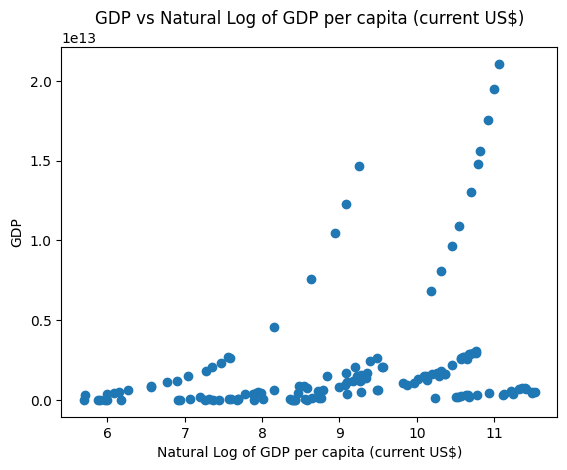

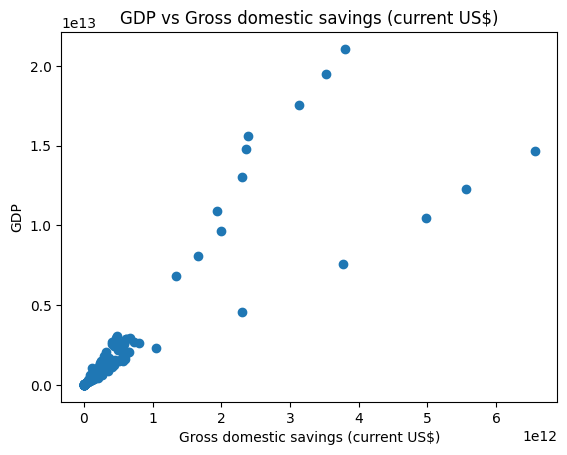

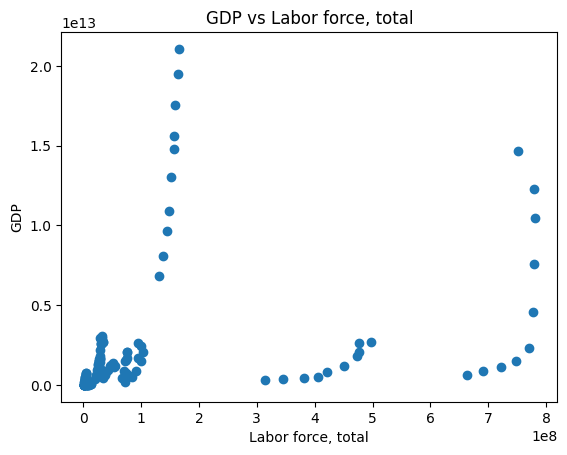

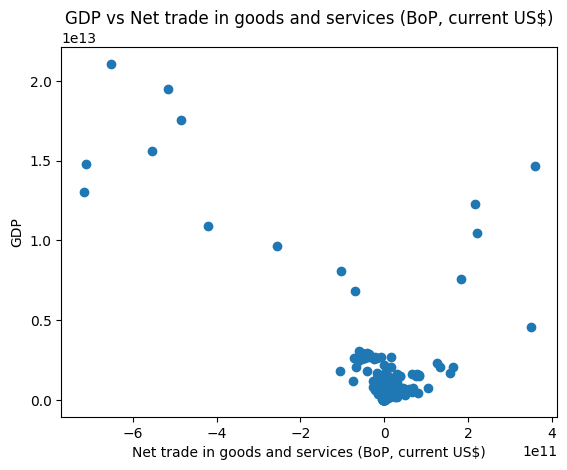

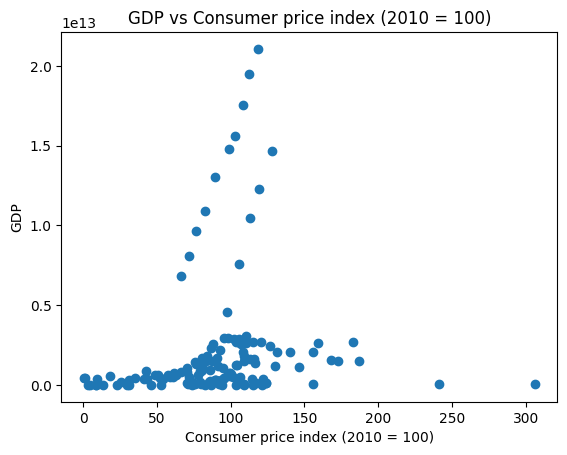

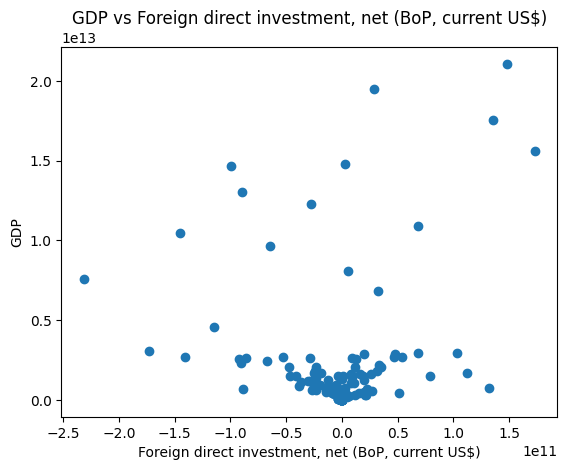

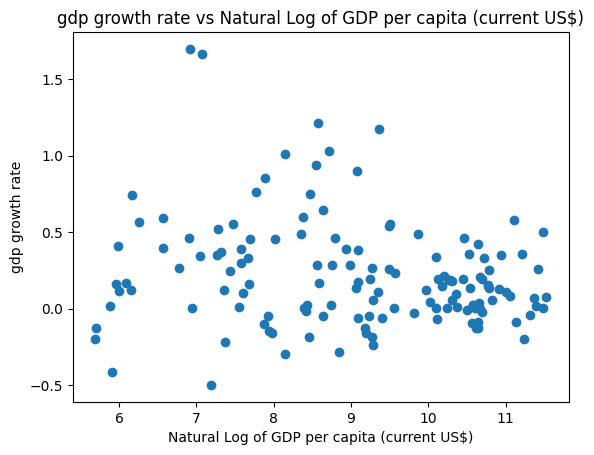

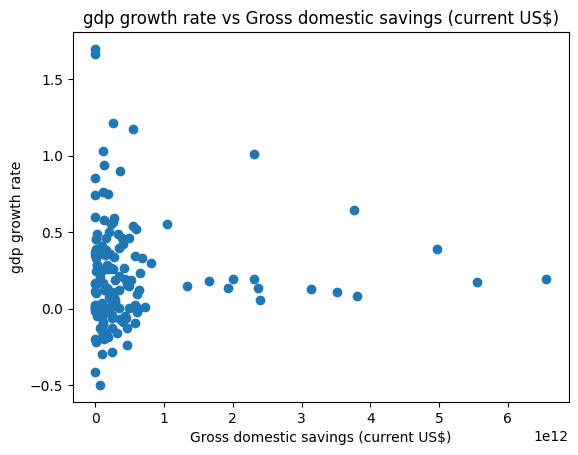

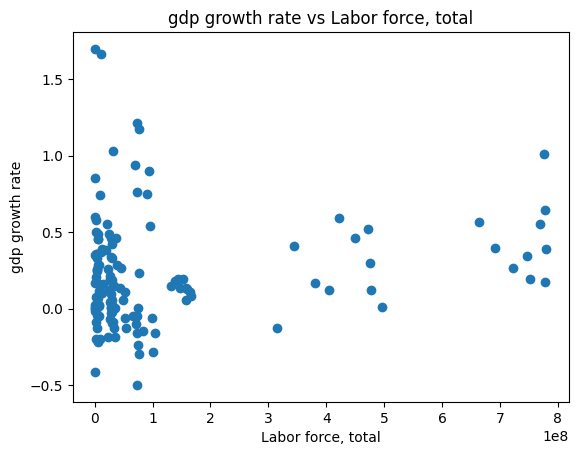

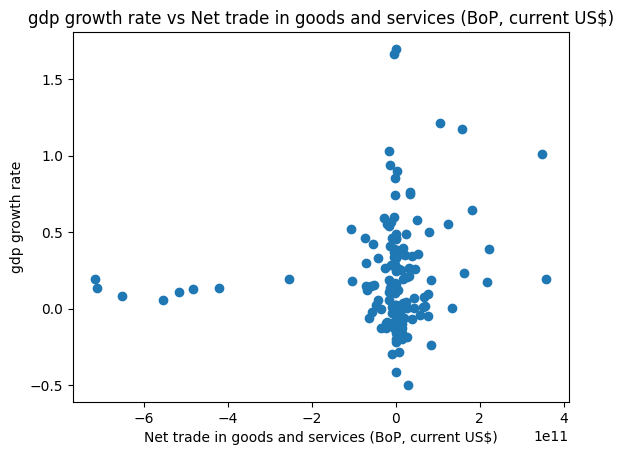

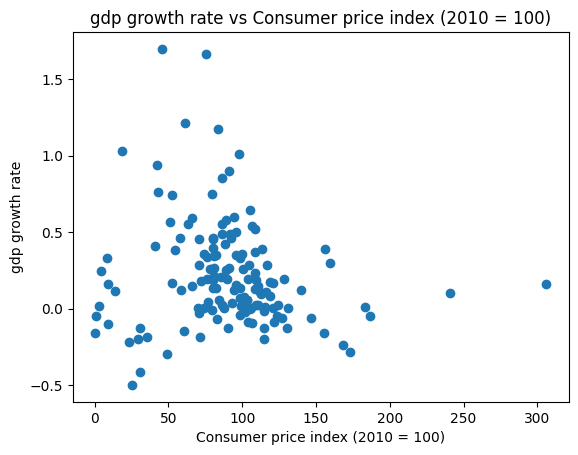

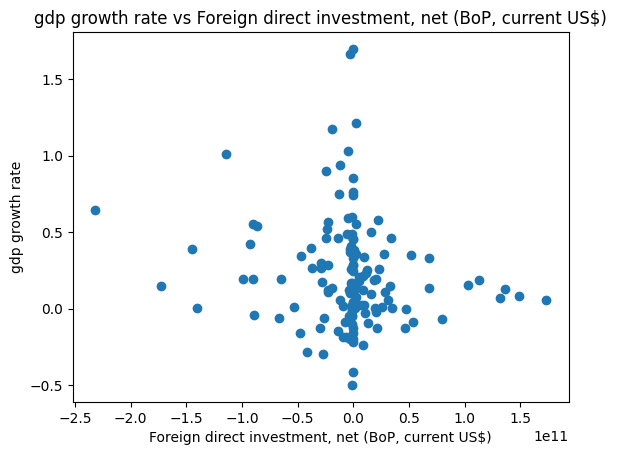

In [5]:
plots.plot_vs_gdp(combined_reg_df)
plots.plot_vs_gdp(combined_reg_df, growth_rate=True)

In [6]:
X, y = regression.create_regression_data_OLS(combined_reg_df)
OLS_model = regression.fit_OLS_model(X, y)
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gdp growth rate   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.634
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.142
Time:                        00:18:27   Log-Likelihood:                -47.512
No. Observations:                 140   AIC:                             109.0
Df Residuals:                     133   BIC:                             129.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\src\utils\regression.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Gross domestic savings (current US$)"] = X["Gross domestic savings (current US$)"]/df["GDP"]
c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\src\utils\regression.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Foreign direct investment, net (BoP, current US$)"] = X["Foreign direct investment, net (BoP, current US$)"]/df["GDP"]
c:\Users\adity\O

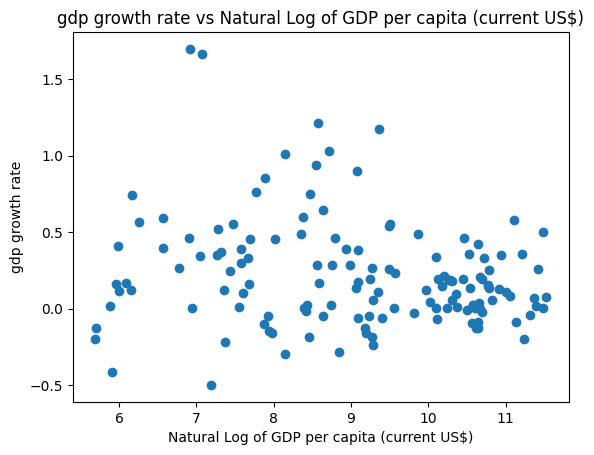

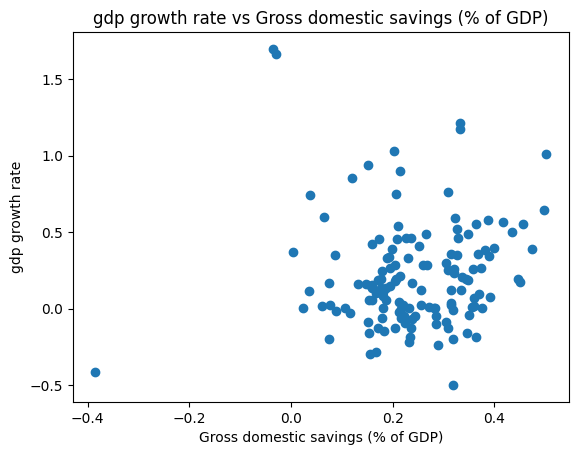

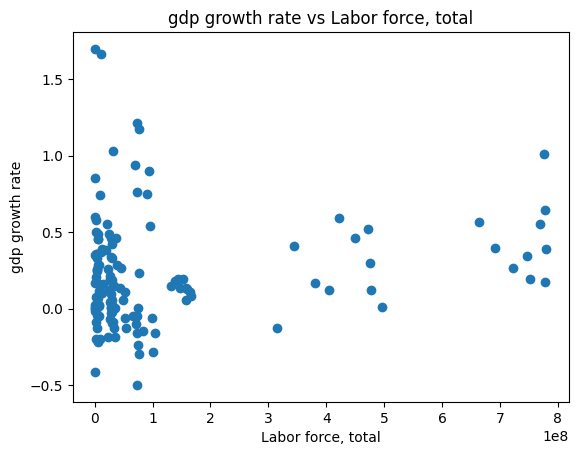

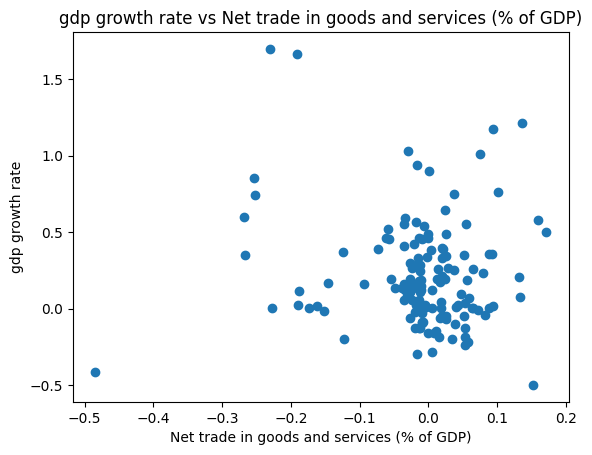

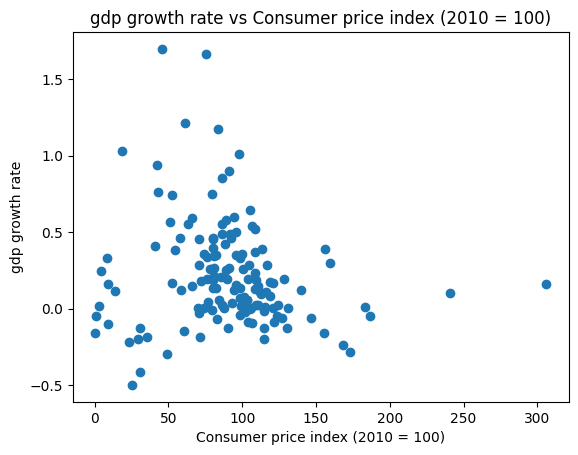

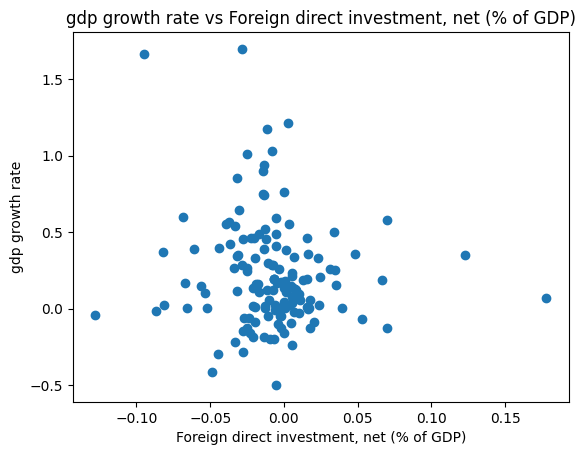

In [7]:
dummy_ratios_X, dummy_ratios_y = regression.create_regression_data_OLS(combined_reg_df, dummies=True, ratios=True)
combined_reg_df_dummy_ratios = pd.concat([dummy_ratios_X, dummy_ratios_y], axis=1)
#plots.plot_vs_gdp(combined_reg_df_dummy_ratios)
plots.plot_vs_gdp(combined_reg_df_dummy_ratios, growth_rate=True)

In [8]:
OLS_model_dummy_ratios = regression.fit_OLS_model(dummy_ratios_X, dummy_ratios_y)
print(OLS_model_dummy_ratios.summary())

                            OLS Regression Results                            
Dep. Variable:        gdp growth rate   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.931
Date:                Thu, 25 Apr 2024   Prob (F-statistic):             0.0605
Time:                        00:18:29   Log-Likelihood:                -44.690
No. Observations:                 140   AIC:                             107.4
Df Residuals:                     131   BIC:                             133.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

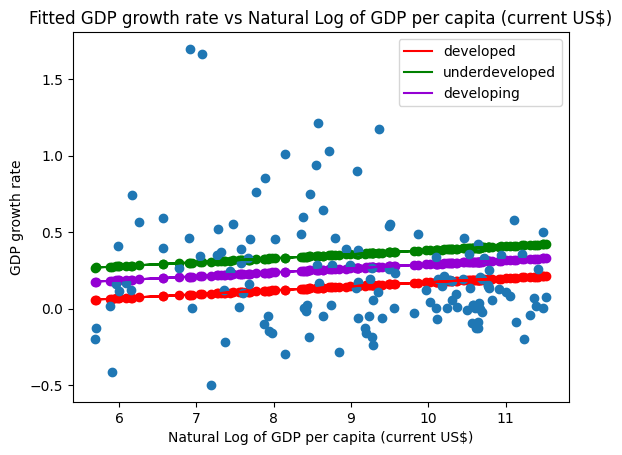

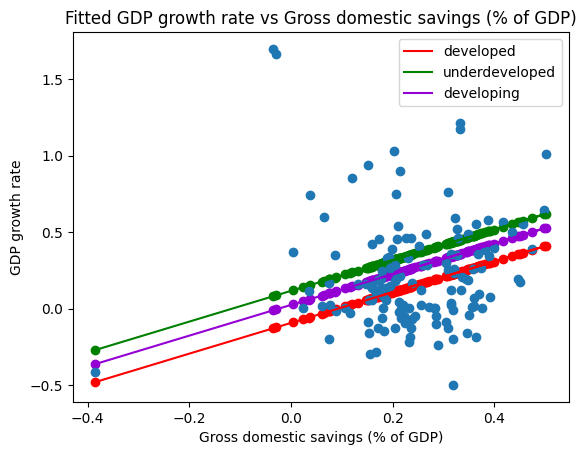

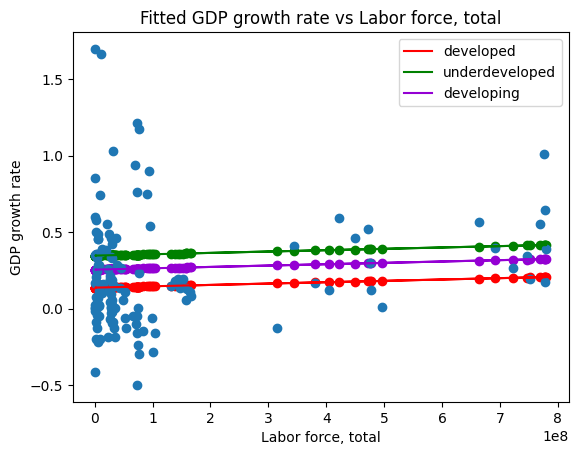

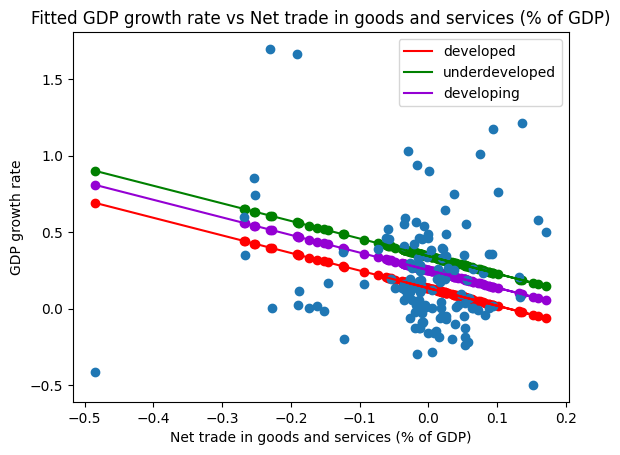

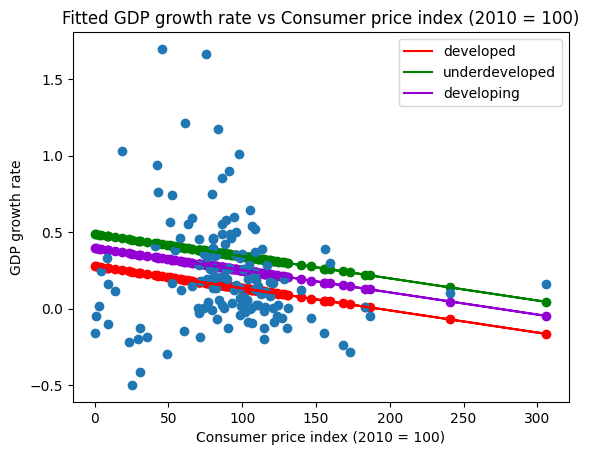

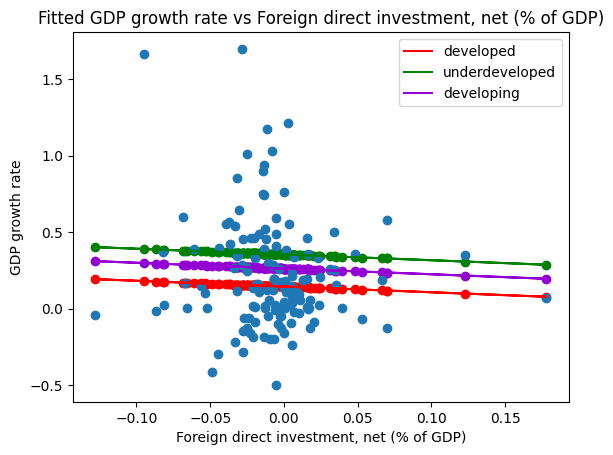

In [9]:
plots.plot_reg_lines(combined_reg_df_dummy_ratios,dummy_ratios_X, dummy_ratios_y, OLS_model_dummy_ratios, dummy=True)

In [10]:
OLS_model_cluster_cov = regression.fit_OLS_model(X, y, cov_type="cluster")
print(OLS_model_cluster_cov.summary())

                            OLS Regression Results                            
Dep. Variable:        gdp growth rate   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2081.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           0.000480
Time:                        00:18:30   Log-Likelihood:                -47.512
No. Observations:                 140   AIC:                             109.0
Df Residuals:                     133   BIC:                             129.6
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 2
  warnings.warn('covariance of constraints does not have full '


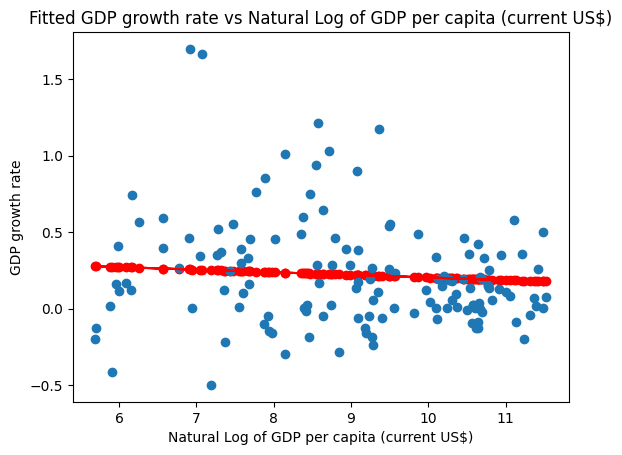

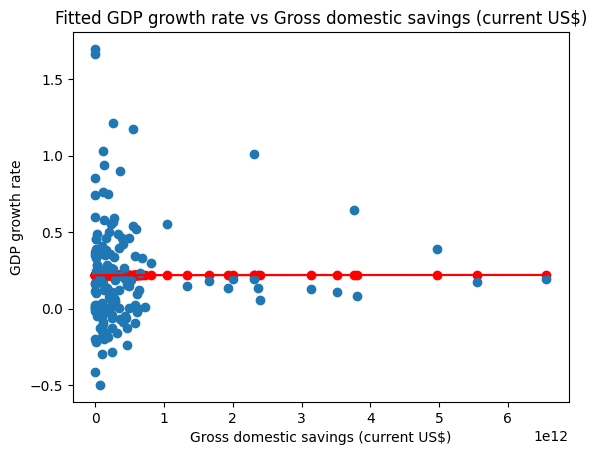

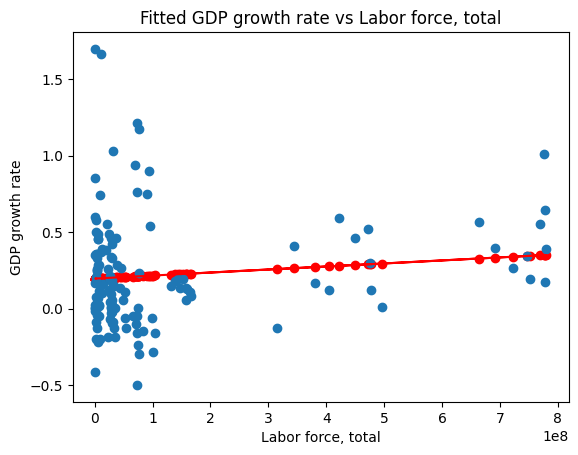

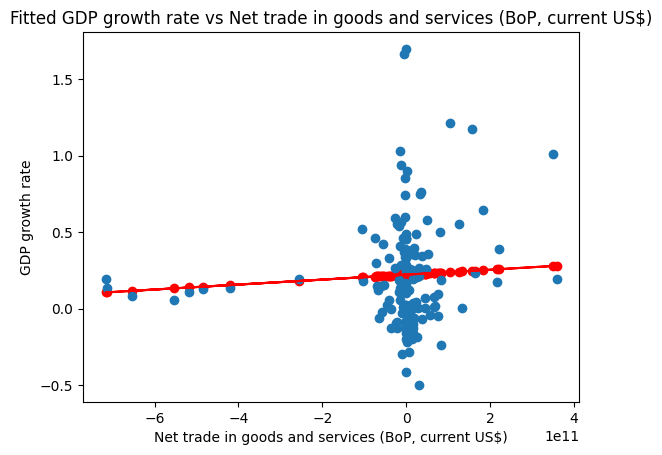

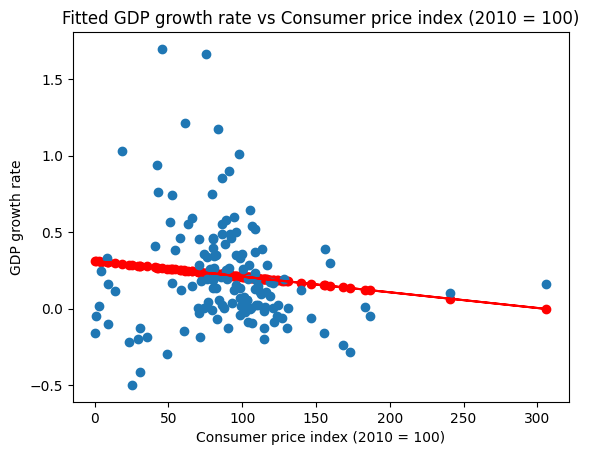

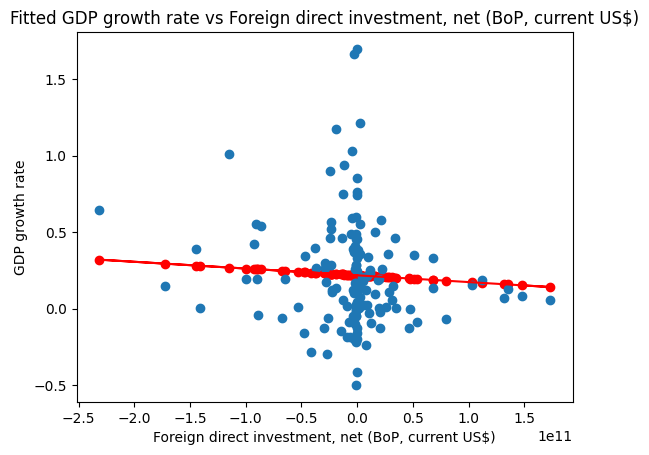

In [11]:
plots.plot_reg_lines(combined_reg_df,X, y, OLS_model)

In [12]:
OLS_model_dummy_ratios_cluster_cov = regression.fit_OLS_model(dummy_ratios_X, dummy_ratios_y, cov_type="cluster")
print(OLS_model_dummy_ratios_cluster_cov.summary())

                            OLS Regression Results                            
Dep. Variable:        gdp growth rate   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     14.21
Date:                Thu, 25 Apr 2024   Prob (F-statistic):             0.0657
Time:                        00:18:31   Log-Likelihood:                -44.690
No. Observations:                 140   AIC:                             107.4
Df Residuals:                     131   BIC:                             133.9
Df Model:                           8                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 2
  warnings.warn('covariance of constraints does not have full '


In [13]:
X_arima, y_arima = arima.get_timeseries_dataset(combined_reg_df)
avg_X_arima = X_arima.resample('YE').mean().dropna()
avg_y_arima = y_arima.resample('YE').mean().dropna()

c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\src\utils\arima.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Year"] = pd.to_datetime(df["Year"], format="%Y", errors='coerce')


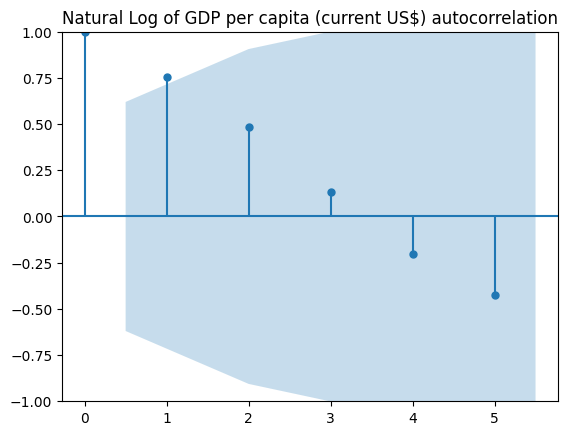

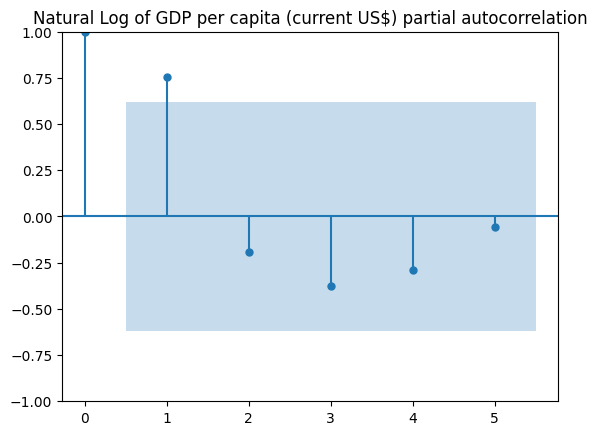

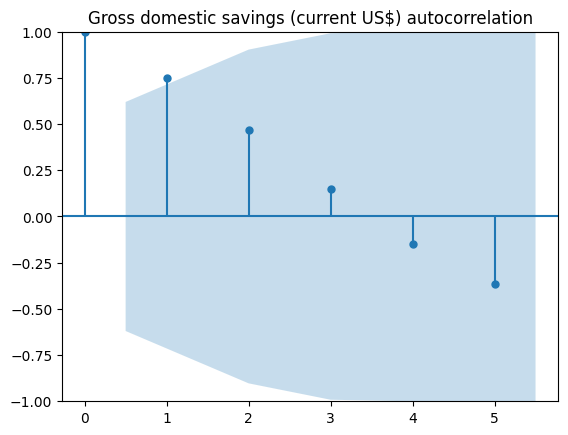

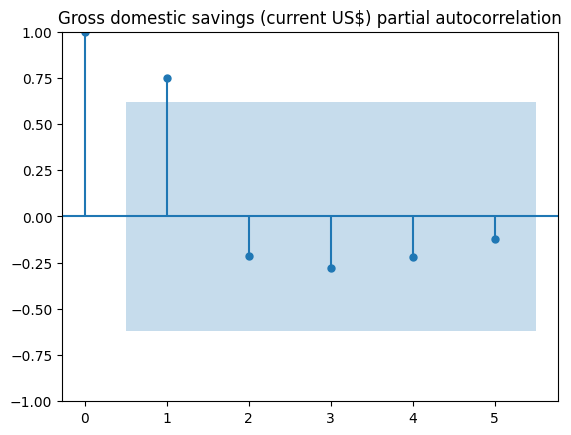

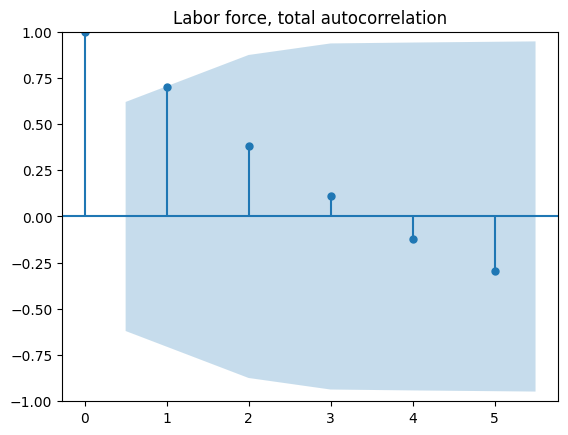

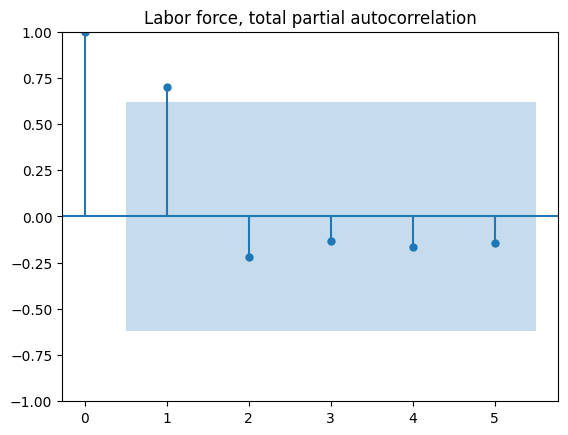

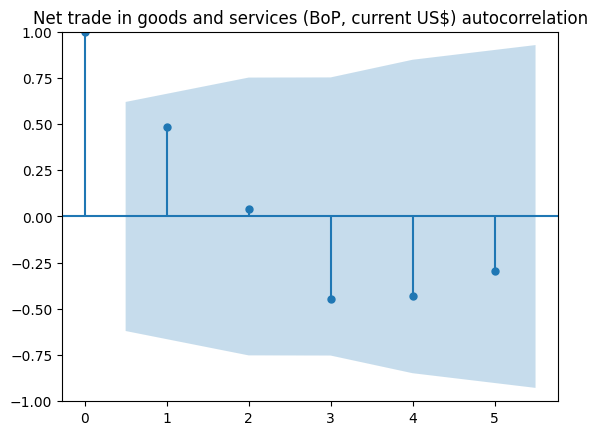

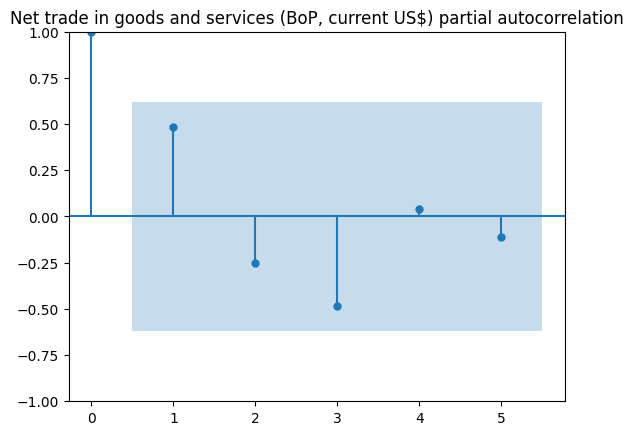

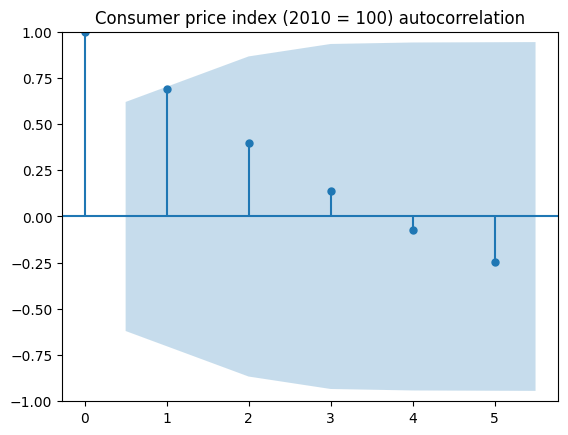

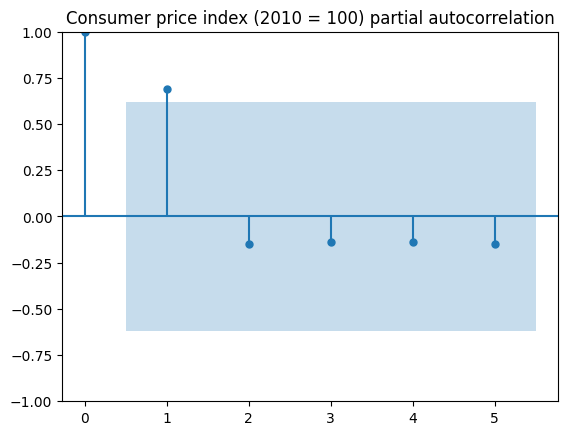

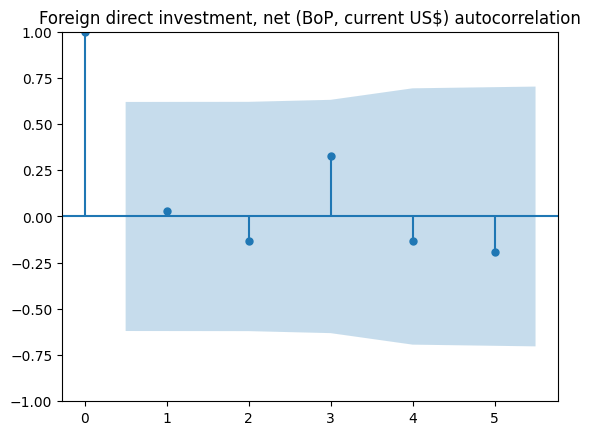

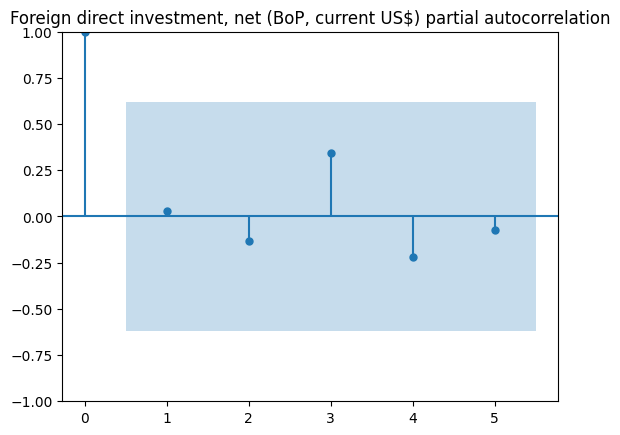

In [14]:
plots.create_acf_pacf_plots(avg_X_arima)

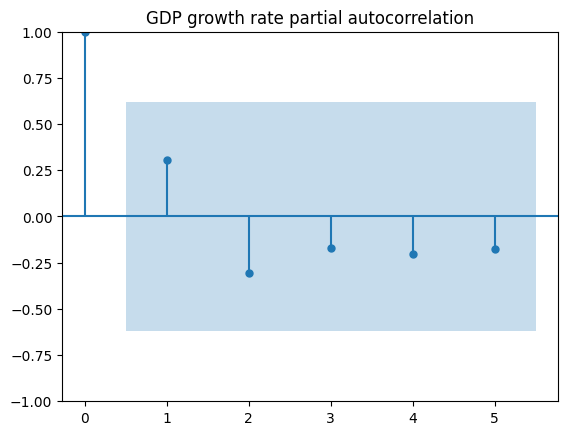

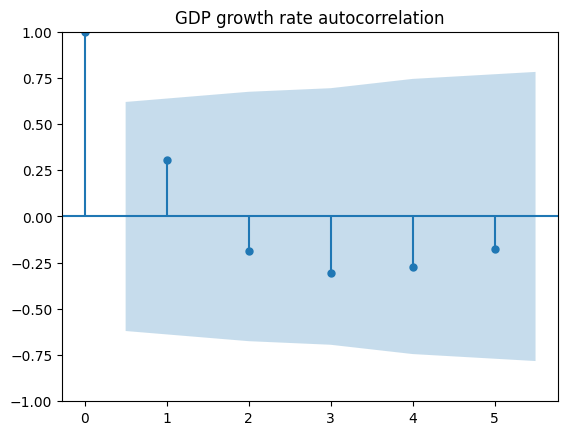

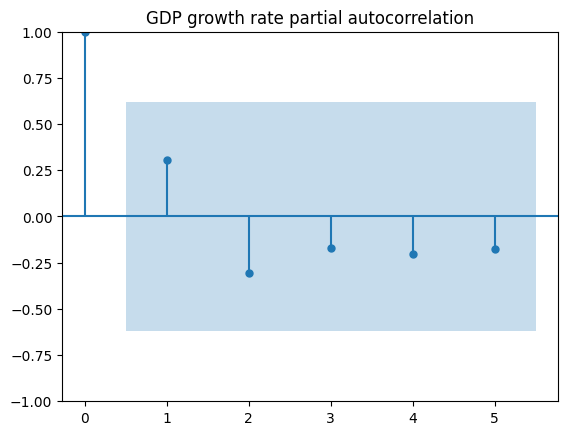

In [15]:
tsaplots.plot_acf(avg_y_arima, alpha=0.05, title=f"GDP growth rate autocorrelation")
tsaplots.plot_pacf(avg_y_arima, alpha=0.05, title=f"GDP growth rate partial autocorrelation")

In [16]:
arimax_model = arima.fit_arima_model(X_arima, y_arima)
print(arimax_model.summary())

                               SARIMAX Results                                
Dep. Variable:        gdp growth rate   No. Observations:                  140
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -49.254
Date:                Thu, 25 Apr 2024   AIC                            118.507
Time:                        00:18:34   BIC                            147.924
Sample:                             0   HQIC                           130.461
                                - 140                                         
Covariance Type:                  opg                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                  0.4444   6.94e-19    6.4e+17      0.000       0.444       0.444
Natural Log

c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\tsa\base\tsa_mode

In [17]:
X_arima_ratios, y_arima_ratios = arima.get_timeseries_dataset(combined_reg_df, ratios=True)
avg_X_arima_ratios = X_arima_ratios.resample('YE').mean().dropna()
avg_y_arima_ratios = y_arima_ratios.resample('YE').mean().dropna()

c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\src\utils\arima.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Gross domestic savings (current US$)"] = X["Gross domestic savings (current US$)"]/df["GDP"]
c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\src\utils\arima.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Foreign direct investment, net (BoP, current US$)"] = X["Foreign direct investment, net (BoP, current US$)"]/df["GDP"]
c:\Users\adity\OneDrive\Do

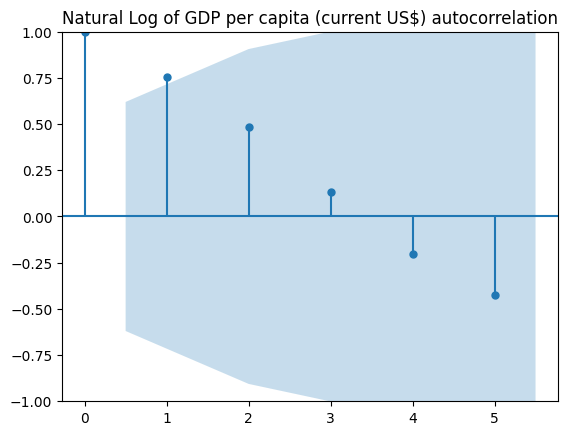

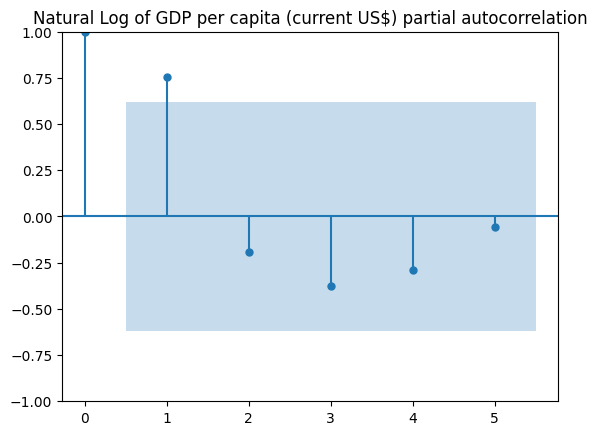

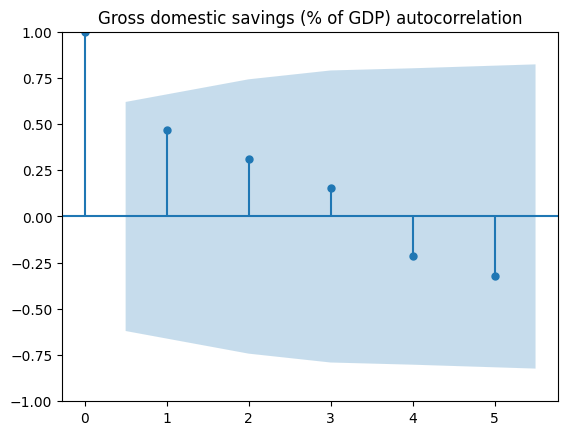

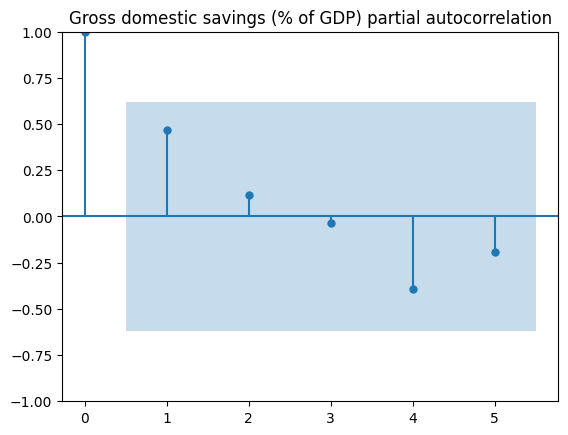

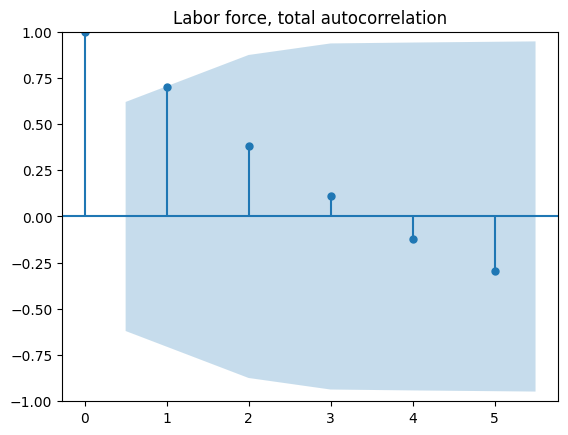

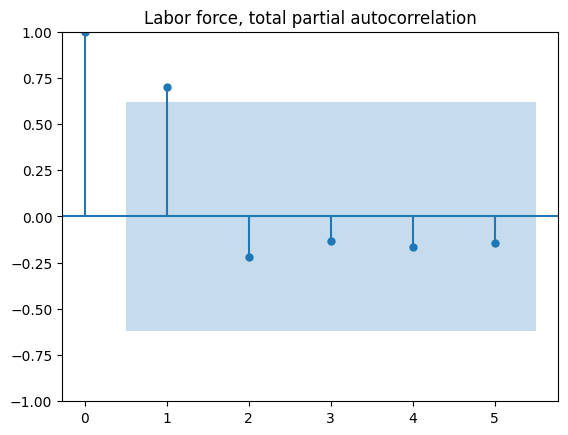

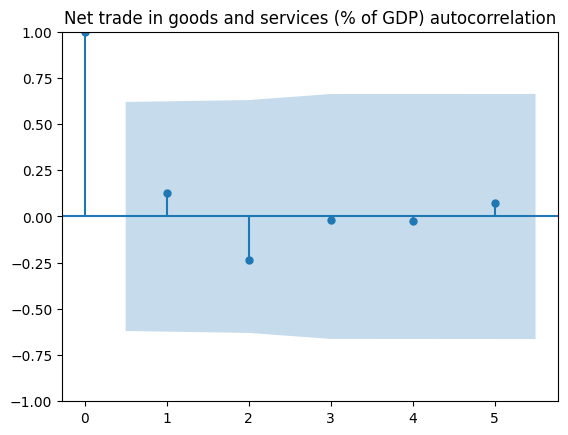

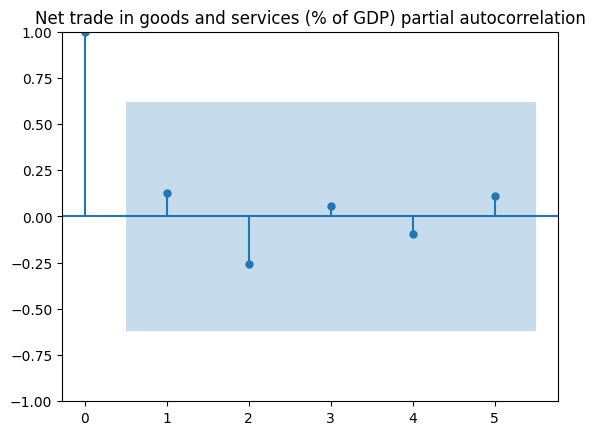

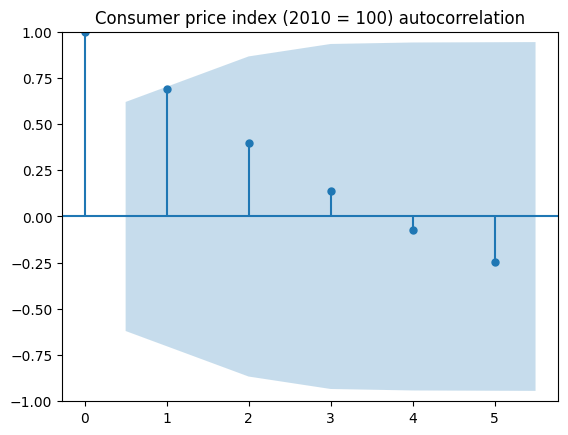

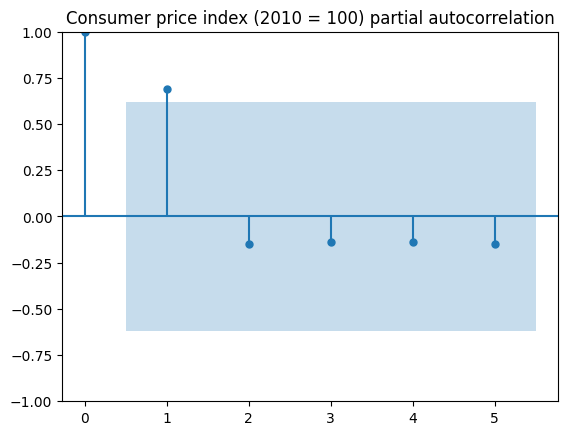

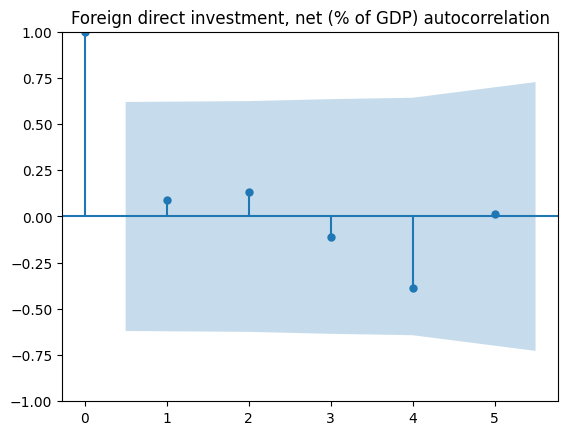

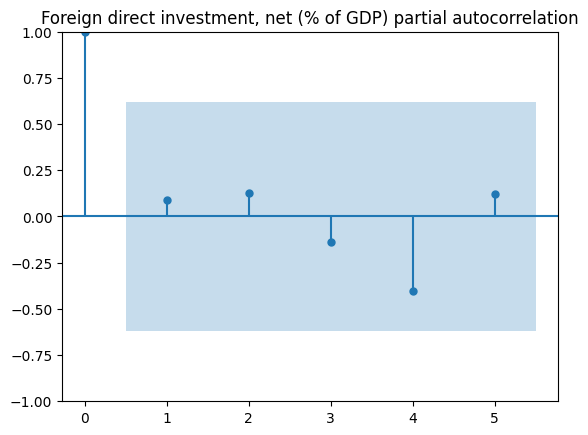

In [18]:
plots.create_acf_pacf_plots(avg_X_arima_ratios)

In [19]:
arimax_model_ratios = arima.fit_arima_model(X_arima_ratios, y_arima_ratios)
print(arimax_model_ratios.summary())

                               SARIMAX Results                                
Dep. Variable:        gdp growth rate   No. Observations:                  140
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -47.383
Date:                Thu, 25 Apr 2024   AIC                            114.767
Time:                        00:18:36   BIC                            144.183
Sample:                             0   HQIC                           126.720
                                - 140                                         
Covariance Type:                  opg                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           0.1715      0.000    627.081      0.000       0.171       0.172
Natural Log of GDP per capita (c

c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\OneDrive\Documents\college\2-2\EGD\egd-assignment\egd-env\lib\site-packages\statsmodels\tsa\base\tsa_mode